In [1]:
%load_ext autoreload
import random
from openff.toolkit.topology import Molecule
import h5py
import numpy as onp
import jax
import jax.numpy as jnp
import jax_md
import espalomax as esp
from concurrent import futures

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
from jax import numpy as jnp
from openff.toolkit.topology import Molecule
from openff.toolkit.typing.engines.smirnoff import ForceField
smiles = "CC"
molecule = Molecule.from_smiles(smiles)
molecule.assign_partial_charges("zeros")
forcefield = ForceField("openff_unconstrained-2.0.0.offxml")
system = forcefield.create_openmm_system(
    molecule.to_topology(),
    charge_from_molecules=[molecule],
)

from jax_md.mm_utils import parameters_from_openmm_system
parameters = parameters_from_openmm_system(system)
from jax_md.mm import PeriodicTorsionParameters, HarmonicAngleParameters
parameters_new = parameters._replace(
        periodic_torsion_parameters=PeriodicTorsionParameters(
            particles=parameters.periodic_torsion_parameters.particles,
            amplitude=jnp.zeros_like(parameters.periodic_torsion_parameters.amplitude),
            periodicity=parameters.periodic_torsion_parameters.periodicity,
            phase=parameters.periodic_torsion_parameters.phase,
        ),
        harmonic_angle_parameters=HarmonicAngleParameters(
            particles=parameters.harmonic_angle_parameters.particles,
            epsilon=jnp.zeros_like(parameters.harmonic_angle_parameters.epsilon),
            length=jnp.zeros_like(parameters.harmonic_angle_parameters.length),
        ),
)
    

molecule.generate_conformers()
coordinate = molecule.conformers[0]._value * 0.1
coordinate = jnp.array(coordinate)

from jax_md import space
displacement_fn, shift_fn = space.free()

from jax_md.mm import mm_energy_fn
energy_fn, _ = mm_energy_fn(
    displacement_fn, default_mm_parameters=parameters,
)

energy_fn_new, _ = mm_energy_fn(
    displacement_fn, default_mm_parameters=parameters_new,
)

In [3]:
from jax_md import simulate
temperature = 1.0
dt = 1e-3
init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
state = init(jax.random.PRNGKey(2666), coordinate)
update = jax.jit(update)

In [4]:
traj = []
for _ in range(100):
    state = update(state)
    traj.append(state.position)
traj = jnp.stack(traj) 
u = jax.vmap(energy_fn_new)(traj)
u = u - esp.mm.get_nonbonded_energy(molecule, traj)
u = u * 0.01

In [5]:
from openmm import unit
for _traj in traj:
    molecule.add_conformer(_traj * unit.nanometer)
molecule.visualize(backend="nglview")

NGLWidget(max_frame=100)

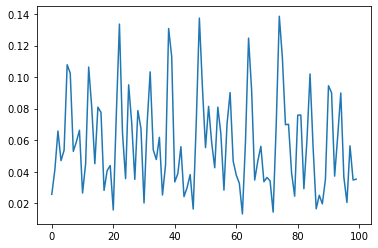

In [6]:
from matplotlib import pyplot as plt
plt.plot(u)
# plt.plot(u_hat)

In [7]:
from flax import linen as nn
class GraphLinear(nn.Module):
    hidden_features: int
    
    @nn.compact
    def __call__(self, graph):
        nodes = nn.Dense(self.hidden_features)(graph.nodes)
        return graph._replace(nodes=nodes)

In [8]:
model = esp.nn.Parametrization(
    # representation=esp.nn.GraphAttentionNetwork(32, 3),
    GraphLinear(32),
    janossy_pooling=esp.nn.JanossyPooling(32, 4),
)

In [9]:
g = esp.Graph.from_openff_molecule(molecule)

/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:66: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()
/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:81: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()


In [10]:
# ff_params["bond"]["coefficients"] = jax.random.normal(jax.random.PRNGKey(0), ff_params["bond"]["coefficients"].shape)
# u = esp.mm.get_energy(ff_params, traj, terms=["bond"])

In [11]:
def get_loss(nn_params, g, x, u):
    ff_params = model.apply(nn_params, g)
    u_hat = esp.mm.get_energy(ff_params, x, terms=["bond"])
    u_hat = u_hat - u_hat.mean()
    u = u - u.mean()
    return jnp.abs(u - u_hat).mean()

# @jax.jit
def step(state, g, x, u):
    nn_params = state.params
    grads = jax.grad(get_loss)(nn_params, g, x, u)
    state = state.apply_gradients(grads=grads)
    return state

import optax
optimizer = optax.chain(
    optax.adam(learning_rate=1e-4),
)

nn_params = model.init(jax.random.PRNGKey(2667), g)
from flax.training.train_state import TrainState
from flax.training.checkpoints import save_checkpoint
state = TrainState.create(
     apply_fn=model.apply, params=nn_params, tx=optimizer,
)

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


In [12]:
import tqdm
import random
for idx_batch in range(10000):
        state = step(state, g, traj, u)
        ff_params = model.apply(state.params, g)
        u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])
        u_hat = u_hat - u_hat.mean()
        u = u - u.mean()
        print(jnp.abs(u - u_hat).mean())

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


0.027563053982501112
0.027562617921760617
0.027562181895735338
0.02756174590499269
0.027561309950096216
0.027560874031603358
0.027560438150064523
0.02756000230602099
0.027559566500005645
0.027559130732540224
0.027558695004136238
0.02755825931529261
0.02755782366649482
0.027557388058215868
0.02755695249091396
0.027556516965032914
0.027556081481001936
0.02755564603923429
0.02755521064012759
0.027554775284064532
0.027554339971411212
0.02755390470251785
0.027553469477719444
0.02755303429733518
0.027552599161668467
0.027552164071007145
0.02755172902562533
0.027551294025780746
0.02755085907171766
0.02755042416366664
0.027549989301844824
0.027549554486455352
0.027549119717689963
0.027548684995727
0.027548250320734016
0.027547815692867583
0.027547381112272125
0.0275469465790836
0.027546512093427684
0.027546077655419957
0.027545643265168257
0.027545208922771784
0.02754477462832172
0.027544340381902094
0.02754390618358986
0.02754347203345486
0.02754303793156168
0.02754260387796823
0.027542169872

0.027393161253499342
0.02739274344492992
0.02739232567965418
0.027391907957657228
0.02739149027892324
0.027391072643436626
0.027390655051181764
0.02739023750214336
0.027389819996305333
0.027389402533652886
0.027388985114170344
0.027388567737841377
0.027388150404651552
0.02738773311458491
0.027387315867625817
0.027386898663759013
0.027386481502968685
0.02738606438523964
0.027385647310556344
0.027385230278903355
0.027384813290265275
0.02738439634462649
0.027383979441971556
0.027383562582284894
0.02738314576555134
0.027382728991755482
0.027382312260881912
0.02738189557291483
0.027381478927839306
0.027381062325640027
0.027380645766300567
0.027380229249806924
0.02737981277614265
0.027379396345292836
0.027378979957241936
0.027378563611974882
0.0273781473094761
0.0273777310497298
0.027377314832721864
0.027376898658435678
0.027376482526856098
0.02737606643796878
0.02737565039175735
0.02737523438820691
0.02737481842730184
0.027374402509027562
0.027373986633368062
0.02737357080030811
0.027373155

0.027229736064969416
0.02722933435898687
0.02722893269056795
0.027228531059698066
0.027228129466365245
0.027227727910555968
0.02722732639225647
0.027226924911454203
0.027226523468135748
0.027226122062287916
0.02722572069389709
0.027225319362951292
0.027224918069436402
0.02722451681333904
0.027224115594646804
0.027223714413346395
0.027223313269424298
0.02722291216286735
0.0272225110936628
0.027222110061797786
0.02722170906725799
0.02722130811003195
0.027220907190105045
0.02722050630746505
0.027220105462098673
0.027219704653992715
0.02721930388313426
0.027218903149510205
0.027218502453107304
0.0272181017939127
0.027217701171912956
0.027217300587095344
0.0272169000394465
0.027216499528953882
0.027216099055604112
0.02721569861938439
0.027215298220281042
0.0272148978582817
0.027214497533373207
0.027214097245542645
0.02721369699477649
0.027213296781062
0.0272128966043863
0.027212496464736648
0.027212096362099484
0.02721169629646227
0.027211296267811557
0.027210896276134613
0.0272104963214188

0.02707191687605183
0.027071529196432676
0.027071141549504633
0.027070753935256157
0.027070366353676135
0.02706997880475377
0.02706959128847727
0.027069203804835726
0.027068816353818075
0.027068428935413082
0.027068041549609744
0.027067654196396423
0.02706726687576252
0.027066879587696255
0.027066492332186987
0.027066105109223595
0.02706571791879448
0.02706533076088902
0.027064943635495803
0.02706455654260371
0.027064169482201767
0.027063782454278987
0.027063395458823716
0.027063008495825273
0.027062621565272386
0.027062234667154114
0.0270618478014593
0.02706146096817696
0.02706107416729554
0.02706068739880467
0.02706030066269301
0.02705991395894896
0.02705952728756217
0.02705914064852108
0.027058754041815018
0.027058367467433002
0.02705798092536337
0.02705759441559557
0.027057207938118676
0.027056821492921164
0.027056435079992478
0.02705604869932118
0.027055662350896674
0.02705527603470779
0.02705488975074315
0.027054503498992334
0.027054117279444116
0.027053731092087356
0.02705334493

0.02692009089669465
0.026919715389627067
0.026919339911138578
0.02691896446122001
0.026918589039862266
0.026918213647055142
0.02691783828278943
0.026917462947055867
0.02691708763984462
0.02691671236114654
0.026916337110951562
0.02691596188925082
0.026915586696034537
0.026915211531293434
0.026914836395017877
0.026914461287198432
0.02691408620782577
0.02691371115689026
0.0269133361343826
0.026912961140293016
0.026912586174612375
0.026912211237331368
0.026911836328440342
0.026911461447929823
0.02691108659579043
0.0269107117720127
0.02691033697658742
0.026909962209505173
0.026909587470756315
0.02690921276033134
0.026908838078221302
0.026908463424416273
0.026908088798907437
0.026907714201685
0.02690733963273941
0.02690696509206166
0.026906590579642224
0.0269062160954719
0.026905841639540982
0.026905467211840395
0.026905092812360542
0.0269047184410922
0.026904344098025914
0.026903969783152595
0.026903595496462613
0.02690322123794641
0.026902847007595362
0.026902472805399442
0.026902098631349

0.026772801640105662
0.026772436795105683
0.026772071975189084
0.02677170718034754
0.02677134241057313
0.02677097766585758
0.02677061294619317
0.026770248251571285
0.02676988358198441
0.0267695189374238
0.026769154317881953
0.026768789723350568
0.026768425153821798
0.026768060609287204
0.026767696089738727
0.0267673315951687
0.02676696712556867
0.02676660268093085
0.026766238261246956
0.026765873866509096
0.026765509496709316
0.026765145151839122
0.02676478083189101
0.026764416536856597
0.026764052266727956
0.026763688021497107
0.0267633238011558
0.026762959605696666
0.0267625954351108
0.026762231289391
0.02676186716852834
0.02676150307251571
0.02676113900134451
0.02676077495500674
0.02676041093349475
0.026760046936800286
0.026759682964915713
0.02675931901783246
0.02675895509554312
0.026758591198039132
0.026758227325313
0.026757863477356206
0.026757499654161524
0.026757135855720038
0.026756772082024826
0.026756408333067108
0.026756044608839465
0.026755680909333307
0.0267553172345414
0.

0.026629138196710388
0.0266287827486765
0.026628427322731425
0.02662807191886785
0.026627716537079266
0.026627361177358304
0.026627005839698445
0.026626650524092504
0.026626295230533434
0.02662593995901435
0.026625584709528697
0.026625229482069447
0.02662487427662898
0.02662451909320113
0.026624163931778903
0.02662380879235514
0.026623453674923022
0.026623098579475663
0.026622743506006095
0.026622388454507557
0.026622033424973
0.02662167841739558
0.026621323431768446
0.026620968468084594
0.026620613526337204
0.026620258606519162
0.02661990370862405
0.026619548832644644
0.0266191939785741
0.026618839146405802
0.026618484336132515
0.026618129547747366
0.026617774781243803
0.026617420036614613
0.026617065313853137
0.026616710612952867
0.026616355933906086
0.026616001276706575
0.02661564664134732
0.02661529202782138
0.02661493743612201
0.02661458286624231
0.02661422831817553
0.026613873791914624
0.026613519287453067
0.02661316480478383
0.026612810343899826
0.02661245590479466
0.02661210148

0.02648969228672349
0.02648934508747844
0.026488997907755416
0.026488650747548356
0.02648830360685112
0.026487956485657837
0.026487609383962565
0.026487262301759427
0.02648691523904176
0.026486568195804236
0.02648622117204051
0.026485874167744644
0.026485527182910834
0.026485180217532656
0.026484833271604624
0.026484486345120455
0.0264841394380742
0.026483792550459993
0.026483445682271563
0.02648309883350318
0.026482752004148808
0.026482405194202356
0.026482058403657978
0.026481711632509702
0.026481364880751472
0.026481018148377236
0.02648067143538118
0.026480324741757728
0.02647997806749999
0.026479631412602563
0.02647928477705969
0.026478938160864912
0.026478591564012628
0.026478244986496712
0.02647789842831133
0.026477551889450477
0.02647720536990819
0.026476858869678464
0.026476512388755577
0.026476165927133324
0.026475819484805804
0.026475473061767178
0.026475126658011622
0.02647478027353302
0.026474433908325296
0.026474087562382693
0.026473741235699344
0.026473394928269625
0.0264

0.026352648713011812
0.02635230884607634
0.026351968996416033
0.026351629164025687
0.02635128934890015
0.026350949551034043
0.02635060977042244
0.02635027000705947
0.02634993026094008
0.026349590532059312
0.026349250820411778
0.02634891112599193
0.026348571448794666
0.026348231788815055
0.026347892146047325
0.026347552520486574
0.02634721291212735
0.026346873320964703
0.026346533746992997
0.026346194190207055
0.026345854650601967
0.026345515128172348
0.02634517562291268
0.026344836134817952
0.02634449666388289
0.02634415721010244
0.02634381777347087
0.026343478353983457
0.026343138951634724
0.02634279956641945
0.026342460198332716
0.026342120847368818
0.02634178151352287
0.026341442196789317
0.02634110289716318
0.026340763614639263
0.026340424349212247
0.026340085100877188
0.02633974586962849
0.026339406655460834
0.02633906745836945
0.02633872827834914
0.026338389115394257
0.026338049969499868
0.026337710840660677
0.02633737172887164
0.026337032634127407
0.0263366935564229
0.0263363544

0.026218693109795327
0.026218359718103303
0.02621802634170892
0.02621769298060682
0.026217359634792874
0.026217026304262273
0.026216692989009933
0.026216359689031587
0.026216026404322156
0.026215693134877528
0.02621535988069263
0.02621502664176267
0.026214693418083343
0.026214360209649627
0.026214027016457198
0.026213693838501063
0.02621336067577651
0.026213027528279375
0.02621269439600448
0.026212361278947216
0.02621202817710302
0.026211695090467474
0.0262113620190357
0.02621102896280249
0.026210695921764216
0.0262103628959154
0.02621002988525175
0.026209696889768614
0.02620936390946112
0.026209030944324616
0.02620869799435464
0.026208365059546643
0.026208032139895827
0.02620769923539721
0.026207366346046635
0.02620703347183907
0.026206700612770324
0.026206367768835306
0.02620603494002966
0.026205702126348512
0.02620536932778721
0.026205036544341503
0.026204703776006234
0.026204371022777333
0.026204038284649518
0.026203705561618943
0.02620337285368008
0.026203040160828767
0.0262027074

0.02608716410125046
0.026086836439974843
0.026086508792223496
0.0260861811579922
0.026085853537276594
0.026085525930072653
0.026085198336375754
0.02608487075618225
0.02608454318948753
0.026084215636287166
0.02608388809657744
0.02608356057035364
0.02608323305761183
0.026082905558347726
0.026082578072556907
0.02608225060023572
0.026081923141379273
0.026081595695983603
0.026081268264044333
0.02608094084555755
0.026080613440518822
0.026080286048924112
0.026079958670769038
0.026079631306049414
0.026079303954760873
0.026078976616899473
0.026078649292460995
0.026078321981440965
0.026077994683835124
0.026077667399639595
0.02607734012885008
0.026077012871462257
0.026076685627472024
0.026076358396875034
0.026076031179667076
0.026075703975844078
0.026075376785401776
0.02607504960833613
0.02607472244464258
0.02607439529431705
0.026074068157355513
0.026073741033753622
0.026073413923507375
0.026073086826612163
0.026072759743064014
0.026072432672858914
0.026072105615992443
0.026071778572460493
0.0260

0.02595778013788051
0.025957457534081307
0.025957134942191026
0.025956812362205976
0.0259564897941222
0.025956167237935635
0.02595584469364258
0.02595552216123915
0.02595519964072131
0.025954877132085274
0.025954554635327226
0.025954232150443266
0.025953909677429353
0.02595358721628172
0.025953264766996335
0.025952942329569302
0.025952619903997096
0.02595229749027566
0.025951975088400744
0.025951652698369087
0.02595133032017641
0.02595100795381872
0.025950685599292585
0.025950363256593723
0.025950040925718624
0.025949718606663143
0.02594939629942329
0.02594907400399543
0.025948751720375744
0.02594842944856014
0.025948107188544737
0.025947784940325885
0.02594746270389958
0.025947140479262033
0.025946818266409172
0.02594649606533722
0.02594617387604259
0.025945851698521004
0.025945529532768786
0.025945207378782028
0.025944885236556886
0.025944563106089502
0.025944240987375973
0.025943918880412583
0.02594359678519509
0.025943274701720073
0.025942952629983643
0.025942630569981515
0.0259423

0.0258320875710134
0.02583178632471939
0.025831485099164705
0.025831183894293695
0.025830882710051038
0.025830581546381508
0.025830280403230352
0.025829979280542564
0.02582967817826362
0.025829377096339447
0.02582907603471577
0.025828774993338702
0.025828473972154483
0.025828172971109654
0.025827871990150717
0.02582757102922476
0.025827270088278818
0.025826969167260082
0.02582666826611603
0.025826367384794314
0.025826066523242854
0.02582576568140934
0.025825464859242295
0.025825164056690168
0.02582486327370111
0.025824562510224275
0.025824261766208504
0.02582396104160285
0.025823660336356538
0.02582335965041921
0.02582305898374046
0.02582275833627036
0.025822457707958348
0.025822157098755075
0.025821856508610932
0.025821555937475874
0.025821255385301518
0.02582095485203807
0.025820654337636587
0.025820353842048727
0.02582005336522557
0.02581975290711883
0.025819452467679894
0.02581915204686112
0.025818851644614338
0.025818551260891782
0.02581825089564595
0.025817950548829335
0.02581765

0.025713403844101503
0.02571310791103959
0.025712811986421346
0.0257125160702312
0.025712220162453052
0.025711924263071104
0.025711628372069698
0.02571133248943288
0.025711036615145552
0.02571074074919153
0.02571044489155555
0.025710149042221984
0.025709853201175383
0.02570955736840027
0.025709261543881503
0.025708965727603356
0.025708669919550706
0.025708374119708326
0.02570807832806075
0.025707782544593175
0.025707486769290144
0.025707191002136857
0.025706895243117964
0.025706599492218637
0.025706303749423825
0.025706008014718604
0.025705712288088024
0.025705416569517487
0.02570512085899189
0.025704825156496715
0.025704529462016998
0.025704233775538283
0.025703938097045853
0.025703642426524977
0.02570334676396123
0.025703051109339993
0.025702755462646866
0.025702459823867513
0.02570216419298732
0.02570186856999195
0.025701572954867392
0.025701277347598906
0.025700981748172425
0.02570068615657391
0.025700390572789243
0.025700094996803948
0.025699799428604057
0.02569950386817576
0.0256

0.02559645389382146
0.025596160411818863
0.025595866934367235
0.025595573461461
0.025595279993094355
0.02559498652926143
0.02559469306995692
0.025594399615174943
0.025594106164909664
0.02559381271915604
0.025593519277908
0.025593225841159944
0.025592932408906633
0.02559263898114183
0.025592345557860954
0.025592052139057506
0.02559175872472653
0.025591465314862172
0.025591171909459236
0.02559087850851216
0.02559058511201509
0.02559029171996311
0.025589998332350303
0.025589704949171416
0.025589411570421012
0.025589118196093698
0.025588824826184044
0.02558853146068655
0.025588238099596074
0.02558794474290706
0.025587651390614124
0.025587358042711995
0.02558706469919528
0.02558677136005879
0.025586478025297225
0.025586184694904937
0.025585891368877185
0.02558559804720818
0.025585304729893014
0.0255850114169262
0.025584718108302856
0.025584424804017302
0.02558413150406456
0.025583838208439475
0.025583544917136793
0.025583251630151276
0.025582958347477886
0.025582665069111367
0.0255823717950

0.025479667206510206
0.025479375195065906
0.025479083186643818
0.025478791181240627
0.025478499178854096
0.025478207179481727
0.02547791518312092
0.025477623189769066
0.02547733119942387
0.02547703921208262
0.025476747227742607
0.02547645524640166
0.025476163268056996
0.02547587129270621
0.02547557932034696
0.02547528735097635
0.02547499538459208
0.025474703421191815
0.025474411460772756
0.025474119503332775
0.02547382754886886
0.025473535597379044
0.025473243648860385
0.02547295170331102
0.025472659760727847
0.025472367821108736
0.025472075884450992
0.025471783950752398
0.025471492020010464
0.025471200092222562
0.02547090816738635
0.025470616245499542
0.025470324326559404
0.025470032410563528
0.025469740497509833
0.025469448587395593
0.025469156680218232
0.025468864775975604
0.02546857287466512
0.025468280976284615
0.02546798908083128
0.02546769718830303
0.025467405298697274
0.025467113412011813
0.025466821528244036
0.025466529647391534
0.0254662377694521
0.025465945894423296
0.025465

0.025363371044649547
0.025363080067617484
0.025362789092803685
0.025362498120206318
0.025362207149823623
0.025361916181653985
0.025361625215695717
0.025361334251947226
0.02536104329040664
0.025360752331072406
0.025360461373943037
0.025360170419016576
0.025359879466291462
0.02535958851576588
0.025359297567438308
0.025359006621307103
0.025358715677370674
0.025358424735626946
0.025358133796074763
0.025357842858712055
0.025357551923537464
0.02535726099054899
0.025356970059745326
0.0253566791311244
0.02535638820468497
0.025356097280425108
0.025355806358343315
0.0253555154384378
0.0253552388893561
0.02535496304426288
0.025354687738023997
0.02535441291772352
0.025354138535685078
0.025353864548953258
0.025353590918824356
0.02535331761042678
0.025353044592340508
0.025352771836255485
0.025352499316663567
0.025352227010581006
0.025351954897298353
0.02535168295815531
0.02535141117633729
0.02535113953669387
0.02535086802557257
0.025350596630671244
0.02535032534090421
0.02535005414628204
0.025349783

0.02526524514207871
0.025265028058174172
0.025264810962797056
0.025264593855946652
0.02526437673762216
0.02526415960782291
0.025263942466548023
0.025263725313796823
0.025263508149568757
0.025263290973862772
0.02526307378667859
0.0252628565880153
0.025262639377872324
0.02526242215624881
0.025262204923144384
0.02526198767855822
0.025261770422489893
0.025261553154938606
0.025261335875903877
0.02526111858538523
0.0252609012833818
0.02526068396989338
0.025260466644919086
0.025260249308458688
0.025260031960511412
0.025259814601076937
0.025259597230154696
0.025259379847744175
0.025259162453844946
0.02525894504845649
0.025258727631578454
0.025258510203210346
0.025258292763351686
0.025258075312002127
0.0252578578491612
0.025257640374828663
0.02525742288900402
0.025257205391686837
0.025256987882876916
0.025256770362573712
0.02525655283077719
0.025256335287486664
0.02525611773270202
0.025255900166422995
0.025255682588649277
0.02525546499938046
0.025255247398616506
0.025255029786356947
0.025254812

0.025177942051217133
0.02517772044434867
0.025177498826434854
0.025177277197478386
0.025177055557481426
0.025176833906446566
0.025176612244376374
0.025176390571272977
0.02517616888713882
0.025175947191976644
0.02517572548578867
0.02517550376857739
0.025175282040345314
0.025175060301094853
0.02517483855082852
0.025174616789548798
0.025174395017258086
0.02517417323395881
0.02517395143965366
0.025173729634344947
0.025173507818035148
0.025173285990726973
0.025173064152422653
0.025172842303124995
0.02517262044283621
0.02517239857155897
0.025172176689295785
0.0251719547960491
0.02517173289182149
0.025171510976615564
0.025171289050433726
0.025171067113278524
0.025170845165152677
0.025170623206058486
0.025170401235998674
0.025170179254975725
0.0251699572629922
0.025169735260050712
0.025169513246153758
0.025169291221303958
0.025169069185504
0.02516884713875624
0.025168625081063347
0.025168403012427884
0.025168180932852478
0.025167958842339928
0.02516773674089242
0.025167514628512837
0.025167292

0.02508889877514091
0.025088672997900945
0.025088447210811618
0.02508822141387656
0.025087995607099033
0.025087769790482314
0.02508754396402969
0.025087318127744604
0.025087092281630228
0.025086866425689955
0.02508664055992729
0.02508641468434528
0.025086188798947442
0.02508596290373709
0.025085736998717398
0.025085511083891947
0.025085285159263827
0.025085059224836483
0.025084833280613276
0.025084607326597508
0.025084381362792604
0.025084155389201668
0.02508392940582814
0.02508370341267538
0.025083477409746844
0.02508325139704559
0.02508302537457519
0.025082799342338966
0.025082573300340028
0.025082347248581924
0.025082121187068058
0.0250818951158014
0.025081669034785717
0.025081442944024035
0.025081216843519796
0.02508099073327647
0.02508076461329719
0.02508053848358536
0.025080312344144342
0.02508008619497752
0.025079860036088114
0.025079633867479564
0.025079407689155106
0.0250791815011182
0.025078955303372067
0.025078729095920065
0.02507850287876563
0.025078276651912233
0.025078050

0.025008439956934785
0.025008267390019698
0.025008096651919533
0.025007925598156833
0.025007754176278596
0.0250075824215514
0.025007410365691173
0.02500723803722112
0.025007065461792825
0.02500689286125416
0.02500672144364831
0.025006549728963483
0.02500637774444435
0.02500620551461489
0.025006033061549464
0.025005861332891108
0.025005689596051008
0.025005517531182707
0.025005345169529045
0.025005172539187884
0.02500500081960658
0.025004828996008022
0.025004656888317652
0.025004484522496973
0.025004311921914626
0.02500413910760539
0.025003967575911716
0.02500379567313761
0.0250036234340717
0.02500345089080126
0.025003278072183582
0.02500310500417018
0.0250029332279237
0.02500276124393451
0.025002588961850713
0.02500241640904884
0.025002243610171237
0.02500207058739901
0.025001897365678705
0.025001725121464844
0.02500155254872845
0.025001379678787423
0.025001207050319402
0.025001034512321253
0.02500086170685445
0.02500068865824805
0.025000516404883887
0.02500034383486489
0.0250001709514

0.02493852992938276
0.024938349486119983
0.024938169655638446
0.02493798958334315
0.024937809237852805
0.024937628645257587
0.024937448485497317
0.024937268388696858
0.024937087951171905
0.024936907205051817
0.024936727235011214
0.024936547116509722
0.024936366714574287
0.024936186056333617
0.024936005166183585
0.02493582511982554
0.02493564496577552
0.024935464457646245
0.024935283628914923
0.024935102509711135
0.02493492258952835
0.02493474240968973
0.024934561934058578
0.024934381191017936
0.02493420020609059
0.02493401900222877
0.02493383864389449
0.024933658377089808
0.02493347774430635
0.02493329678022595
0.024933115516062764
0.02493293474288139
0.024932754307905584
0.0249325735829834
0.024932392595916984
0.024932211371708295
0.02493203052700212
0.02493184991407867
0.024931668948979472
0.0249314876650185
0.024931306909447927
0.02493112619749419
0.024930945207407237
0.024930763965806547
0.024930582601294916
0.024930401712845513
0.02493022048320004
0.024930039721240603
0.0249298587

0.024875745476228922
0.02487559550041024
0.024875445501772193
0.024875295480323294
0.0248751454360715
0.024874995369025
0.024874845279192183
0.024874695166581102
0.024874545031200266
0.024874394873057502
0.024874244692161342
0.024874094488519863
0.024873944262141436
0.02487379401303417
0.024873643741206288
0.024873493446666083
0.024873343129421747
0.02487319278948162
0.024873042426853745
0.024872892041546416
0.02487274163356808
0.024872591202926644
0.02487244074963065
0.02487229027368811
0.024872139775107337
0.024871989253896647
0.02487183871006425
0.024871688143618318
0.024871537554567204
0.02487138694291904
0.0248712363086822
0.024871085651864914
0.024870934972475466
0.024870784270521692
0.02487063354601252
0.024870482798955734
0.02487033202935971
0.024870181237232877
0.02487003042258319
0.02486987958541905
0.024869728725748677
0.024869577843580556
0.02486942693892262
0.024869276011783303
0.024869125062170868
0.024868974090093535
0.024868823095559583
0.02486867207857721
0.02486852103

0.024814497125309337
0.02481433874223739
0.024814180339637462
0.02481402191751747
0.024813863475885625
0.02481370501475023
0.02481354653411939
0.02481338803400136
0.024813229514404234
0.024813070975336325
0.024812912416805614
0.02481275383882059
0.024812595241389
0.024812436624519336
0.02481227798821982
0.024812119332498456
0.02481196065736338
0.02481180196282302
0.02481164324888526
0.024811484515558483
0.024811325762850726
0.024811166990770284
0.024811008199325163
0.02481084938852352
0.024810690558373788
0.02481053170888382
0.024810372840061885
0.02481021395191623
0.02481005504445486
0.02480989611768613
0.024809737171617944
0.024809578206258592
0.02480941922161625
0.024809260217699025
0.024809101194515164
0.024808942152072584
0.024808783090379562
0.024808624009444308
0.024808464909274876
0.02480830578987947
0.024808146651266134
0.024807987493443137
0.024807828316418503
0.024807669120200476
0.024807509904796975
0.024807350670216444
0.024807191416466697
0.024807032143556066
0.0248068728

0.024760332974492264
0.024760202055159317
0.024760071116708735
0.02475994015914581
0.02475980918247533
0.024759678186702504
0.02475954717183236
0.02475941613786999
0.024759285084820268
0.024759154012688526
0.02475902292147965
0.024758891811198742
0.024758760681850928
0.02475862953344123
0.024758498365974716
0.024758367179456498
0.02475823597389171
0.02475810474928536
0.024757973505642506
0.024757842242968453
0.024757710961267998
0.024757579660546352
0.024757448340808674
0.02475731700206012
0.02475718564430557
0.02475705426755037
0.024756922871799585
0.02475679145705822
0.02475666002333142
0.02475652857062432
0.024756397098942128
0.024756265608289835
0.024756134098672673
0.024756002570095748
0.02475587102256415
0.024755739456083087
0.024755607870657583
0.024755476266292913
0.024755344642994084
0.024755213000766316
0.02475508133961484
0.024754949659544598
0.02475481796056097
0.02475468624266891
0.024754554505873713
0.024754422750180582
0.024754290975594524
0.02475415918212084
0.024754027

0.02470690988328829
0.02470677179405878
0.024706633687873545
0.02470649556473819
0.024706357424658227
0.024706219267639603
0.024706081093687642
0.02470594290280836
0.024705804695007327
0.02470566647029015
0.024705528228662416
0.024705389970130148
0.024705251694698643
0.024705113402373816
0.02470497509316119
0.024704836767066595
0.02470469842409563
0.024704560064254012
0.02470442168754734
0.024704283293981357
0.024704144883561686
0.024704006456294083
0.02470386801218414
0.02470372955123766
0.024703591073460256
0.024703452578857536
0.024703314067435284
0.024703175539199176
0.024703036994154798
0.024702898432307947
0.024702759853664213
0.02470262125822929
0.024702482646008956
0.0247023440170088
0.02470220537123458
0.02470206670869187
0.024701928029386436
0.02470178933332397
0.02470165062050999
0.024701511890950344
0.024701373144650676
0.02470123438161675
0.024701095601854066
0.024700956805368452
0.0247008179921656
0.02470067916225102
0.02470054031563061
0.024700401452309943


In [102]:
ff_params["bond"]["coefficients"].shape

(7, 2)

In [103]:
from sklearn.metrics import r2_score
r2_score(u - u.mean(), u_hat - u_hat.mean())

-0.011943442802928583

In [104]:
jnp.abs((u - u.mean()) - (u_hat - u_hat.mean()))

DeviceArray([0.03127977, 0.01853765, 0.00460093, 0.01278062, 0.00332484,
             0.05260456, 0.04628405, 0.00640811, 0.00333191, 0.00350468,
             0.03374005, 0.0119268 , 0.05111696, 0.02430152, 0.01400813,
             0.01972073, 0.01679457, 0.03018039, 0.01564745, 0.01280807,
             0.0438913 , 0.01408776, 0.0698508 , 0.00322234, 0.02182646,
             0.03954824, 0.01443736, 0.02387881, 0.01755908, 0.00627833,
             0.03890035, 0.01296347, 0.04638005, 0.00457136, 0.01283746,
             0.00049154, 0.0345746 , 0.01286246, 0.07559222, 0.05776838,
             0.02388589, 0.02141105, 0.00578857, 0.03643883, 0.02866809,
             0.01929904, 0.04228897, 0.01074716, 0.07464149, 0.03190672,
             0.00309855, 0.02552928, 0.00268588, 0.01574208, 0.01982423,
             0.00170894, 0.03265776, 0.01142482, 0.03269886, 0.01101374,
             0.02120254, 0.02743992, 0.04623767, 0.00155293, 0.06889209,
             0.03604375, 0.02276416, 0.01381784, 0.

In [105]:
ff_params = model.apply(state.params, g)
u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


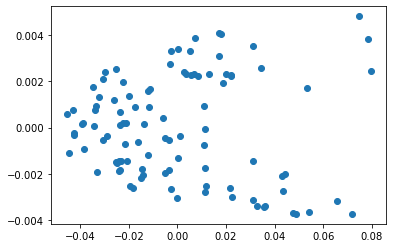

In [106]:
from matplotlib import pyplot as plt
plt.scatter(u - u.mean(), u_hat - u_hat.mean())

In [107]:
u_hat

DeviceArray([2.68973561, 2.69257409, 2.69396892, 2.6925721 , 2.68969383,
             2.68795225, 2.68894515, 2.69209858, 2.69508899, 2.69552315,
             2.69300886, 2.68962427, 2.68797896, 2.68906481, 2.69183227,
             2.69395724, 2.69357766, 2.69111516, 2.68904452, 2.68949433,
             2.6924451 , 2.69570971, 2.69648426, 2.6939384 , 2.69023143,
             2.68827597, 2.68914481, 2.69180086, 2.69398482, 2.69389249,
             2.69186428, 2.68992335, 2.68966997, 2.69123221, 2.69333624,
             2.6940828 , 2.69258554, 2.68988493, 2.68793621, 2.68802267,
             2.69017845, 2.69302515, 2.69443057, 2.69342509, 2.69128498,
             2.69022753, 2.69142434, 2.69399184, 2.69548561, 2.69422826,
             2.69112036, 2.68865518, 2.68864129, 2.6910258 , 2.69388269,
             2.69496217, 2.69375054, 2.69160576, 2.69023265, 2.69048587,
             2.69187345, 2.69285058, 2.69226487, 2.69036108, 2.68851634,
             2.68827241, 2.69023826, 2.69323431, 2.

In [108]:
ff_params["bond"]["coefficients"] = jnp.zeros_like(ff_params["bond"]["coefficients"])

In [109]:
ff_params["bond"]["coefficients"]

DeviceArray([[0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.]], dtype=float64)